In [ ]:
#패키지가 없을 경우 패키지 다운
#!pip install catboost
#!pip install shap

###필요한 패키지 로드

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = 'C:/Windows/Fonts/gulim.ttc'
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name

###데이터 불러오기

In [ ]:
data = pd.read_csv("../DAT/data.csv", encoding = "cp949")
quality = pd.read_excel("../DAT/quality.xlsx")
train = pd.read_csv("../DAT/train.csv", encoding="cp949")
train = train.rename(columns = {"Unnamed: 0" : "index"}, inplace=False)

### 결측치 확인

In [ ]:
data.isnull().sum()

###선형회귀를 이용한 결측치 대치

In [ ]:
def apply_linear_regression(df, column_pair):
    data1 = df.copy()  # 데이터프레임을 복사하여 원본 데이터에 영향을 주지 않도록 합니다.

    # 데이터 프레임 내에서 결측치가 없는 행만 선택
    data2 = data1.dropna(subset=[column_pair[0], column_pair[1]])

    if data2.empty:
        return data1  # 결측치가 없는 경우 예측 작업을 건너뛰기

    model = LinearRegression()
    model.fit(data2[[column_pair[0]]], data2[[column_pair[1]]])

    data2_to_predict = data1[(data1[column_pair[1]].isna()) & (data1[column_pair[0]].notna())]  # column_pair[0] 열의 결측치가 있는 행만 선택

    if not data2_to_predict.empty:
        y = model.predict(data2_to_predict[[column_pair[0]]])
        data1.loc[data2_to_predict.index, column_pair[1]] = y

    return data1

# 고유한 배정번호 추출
number_list = data["배정번호"].unique()

# 열 조합 리스트
columns = [["건조 1존 OP", "건조로 온도 1 Zone"],
           ["건조 2존 OP", "건조로 온도 2 Zone"],
           ["소입1존 OP", "소입로 온도 1 Zone"],
           ["소입2존 OP", "소입로 온도 2 Zone"],
           ["소입3존 OP", "소입로 온도 3 Zone"],
           ["소입4존 OP", "소입로 온도 4 Zone"]]


# 모든 조합에 대해 선형 회귀 적용
for number in tqdm(number_list, desc="Processing"):
    condition = (data["배정번호"] == number)
    for column_pair in columns:
        data[condition] = apply_linear_regression(data[condition], column_pair)

Processing:   0%|          | 0/136 [00:00<?, ?it/s]

In [ ]:
def apply_linear_regression(df, column_pair):
    data1 = df.copy()  # 데이터프레임을 복사하여 원본 데이터에 영향을 주지 않도록 합니다.

    # 데이터 프레임 내에서 결측치가 없는 행만 선택
    data2 = data1.dropna(subset=[column_pair[0], column_pair[1]])

    if data2.empty:
        return data1  # 결측치가 없는 경우 예측 작업을 건너뛰기

    model = LinearRegression()
    model.fit(data2[[column_pair[1]]], data2[[column_pair[0]]])

    data2_to_predict = data1[(data1[column_pair[0]].isna()) & (data1[column_pair[1]].notna())]  # column_pair[0] 열의 결측치가 있는 행만 선택

    if not data2_to_predict.empty:
        y = model.predict(data2_to_predict[[column_pair[1]]])
        data1.loc[data2_to_predict.index, column_pair[0]] = y

    return data1

# 고유한 배정번호 추출
number_list = data["배정번호"].unique()

# 열 조합 리스트
columns = [["건조 1존 OP", "건조로 온도 1 Zone"],
           ["건조 2존 OP", "건조로 온도 2 Zone"],
           ["소입1존 OP", "소입로 온도 1 Zone"],
           ["소입2존 OP", "소입로 온도 2 Zone"],
           ["소입3존 OP", "소입로 온도 3 Zone"],
           ["소입4존 OP", "소입로 온도 4 Zone"]]


# 모든 조합에 대해 선형 회귀 적용
for number in tqdm(number_list, desc="Processing"):
    condition = (data["배정번호"] == number)
    for column_pair in columns:
        data[condition] = apply_linear_regression(data[condition], column_pair)

Processing:   0%|          | 0/136 [00:00<?, ?it/s]

In [ ]:
data.isnull().sum()

###배정번호별 각 변수의 평균을 이용하여 결측치 대치

In [ ]:
column_list = data.columns[2:]
number_list = data["배정번호"].unique()

for number in tqdm(number_list):
    # 해당 배정번호의 데이터프레임 선택
    subset = data[data["배정번호"] == number]
    # 선택된 데이터프레임의 결측치를 해당 열의 평균값으로 대체
    data.loc[subset.index, column_list] = subset[column_list].fillna(subset[column_list].mean())

  0%|          | 0/136 [00:00<?, ?it/s]

In [1]:
data.isnull().sum()

NameError: ignored

In [ ]:
data3=data.copy()
data3 = data3.drop(columns = ["소입로 CP 모니터 값", "솔트조 온도 1 Zone"], axis=1)

###groupby를 활용하여 새 데이터셋 정의

In [ ]:
# 계산할 통계량 함수 정의
def q25(x):
    return np.percentile(x, 25)

def q50(x):
    return np.percentile(x, 50)

def q75(x):
    return np.percentile(x, 75)

def cv(x):
    if np.mean(x) == 0:
        return np.nan
    return np.std(x) / np.mean(x) * 100

# "배정번호" 열을 기준으로 그룹화하고 원하는 통계량을 계산
result = data3.groupby("배정번호").agg(["mean","std","max","min",q25,q50,q75, cv])

In [ ]:
chg_name = {'mean': '_Mean', 'std': '_Std', "max" : "_Max", "min" : "_Min",
            "q25" : "_Q25", "q50" : "_Q50", "q75" : "_Q75", "cv" : "_CV"}
result.columns = list(map(lambda x: x[0] + chg_name[x[1]], result.columns))
result.reset_index(drop=False, inplace=True)

In [ ]:
quality["불량률"] = quality["불량수량"] / quality["총수량"]
quality = quality.drop(["작업일", "공정명", "설비명", "양품수량", "불량수량", "총수량"], axis=1)
quality

,배정번호,불량률
0,102410,0.000198
1,102585,0.000334
2,102930,0.000503
3,103142,0.000174
4,103675,0.000134
...,...,...
131,147292,0.000274
132,147546,0.000267
133,147982,0.000293
134,147996,0.000298


In [ ]:
total = pd.merge(quality, result, on='배정번호', how='left')
total

,배정번호,불량률,건조 1존 OP_Mean,건조 1존 OP_Std,건조 1존 OP_Max,건조 1존 OP_Min,건조 1존 OP_Q25,건조 1존 OP_Q50,건조 1존 OP_Q75,건조 1존 OP_CV,...,솔트 컨베이어 온도 2 Zone_Q75,솔트 컨베이어 온도 2 Zone_CV,솔트조 온도 2 Zone_Mean,솔트조 온도 2 Zone_Std,솔트조 온도 2 Zone_Max,솔트조 온도 2 Zone_Min,솔트조 온도 2 Zone_Q25,솔트조 온도 2 Zone_Q50,솔트조 온도 2 Zone_Q75,솔트조 온도 2 Zone_CV
0,102410,0.000198,72.252727,3.696537,83.4128,55.8907,71.119075,72.56910,73.919450,5.115773,...,285.9740,2.153657,329.070466,0.116518,329.300,328.805,328.96425,329.089,329.171,0.035406
1,102585,0.000334,72.235643,3.365000,82.5948,55.4900,70.880000,72.54800,74.229450,4.658190,...,286.8560,2.559679,328.924151,0.089118,329.121,328.689,328.86700,328.937,328.992,0.027093
2,102930,0.000503,70.720207,3.231776,81.7570,53.9100,69.656725,71.17550,72.591900,4.569722,...,285.5810,2.386257,329.148656,0.115567,329.383,328.787,329.08400,329.180,329.233,0.035110
3,103142,0.000174,72.424229,2.635245,82.3991,55.6307,71.171650,72.54490,73.954300,3.638566,...,285.5720,2.341108,329.073103,0.100487,329.267,328.623,329.05300,329.100,329.134,0.030536
4,103675,0.000134,72.774648,4.159221,84.5765,52.9816,71.879925,73.41015,74.829000,5.714746,...,282.2200,1.933191,329.114051,0.078846,329.320,328.900,329.05600,329.108,329.177,0.023955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,147292,0.000274,69.486127,3.123360,78.2255,53.7822,68.145100,69.90460,71.509500,4.494829,...,287.0540,2.387811,332.210106,0.129175,332.463,331.751,332.18800,332.248,332.287,0.038883
132,147546,0.000267,69.718808,2.662344,79.5047,53.0555,68.678650,70.09770,71.344750,3.818619,...,286.4180,2.361586,332.162465,0.260713,332.432,331.272,332.20100,332.257,332.297,0.078488
133,147982,0.000293,69.799029,3.164459,79.7104,54.4260,68.727000,70.32180,71.749950,4.533550,...,286.4390,2.335099,332.125705,0.118017,332.335,331.655,332.10500,332.162,332.198,0.035533
134,147996,0.000298,69.991809,3.564122,80.8309,56.2065,68.682200,70.68730,72.386875,5.092040,...,287.2325,2.418259,332.088618,0.237818,332.428,331.343,331.97000,332.178,332.266,0.071611


### 불량률에 대한 히스토그램

In [ ]:
sns.histplot(total["불량률"])
plt.axvline(x=total["불량률"].quantile(0.75), color = 'red')
plt.axvline(x=total["불량률"].quantile(0.5), color = "blue")
plt.show()

###불량단계 구분

In [ ]:
quantile_75th = total["불량률"].quantile(0.75)
total["상태"] = total["불량률"].apply(lambda x: "위험" if x >= quantile_75th else "안정")

In [ ]:
total.corr()

### 상관계수가 0.8이상인 변수 제거

In [ ]:
total=total.drop(columns=['소입1존 OP_Min','솔트 컨베이어 온도 1 Zone_Std','솔트 컨베이어 온도 1 Zone_Max','솔트 컨베이어 온도 1 Zone_CV','솔트 컨베이어 온도 2 Zone_Std','솔트 컨베이어 온도 2 Zone_Min','솔트 컨베이어 온도 2 Zone_Q25','솔트 컨베이어 온도 2 Zone_CV','소입로 온도 1 Zone_Std','소입로 온도 1 Zone_CV','소입로 온도 2 Zone_Std','소입로 온도 2 Zone_CV','소입로 온도 3 Zone_Std','소입로 온도 3 Zone_Max','소입로 온도 3 Zone_CV','소입로 온도 4 Zone_Mean','소입로 온도 4 Zone_Std','소입로 온도 4 Zone_Max','소입로 온도 4 Zone_CV'],axis=1)

### 상관계수가 0.7이상인 변수 제거

In [ ]:
total=total.drop(columns=['건조로 온도 1 Zone_Std','건조로 온도 1 Zone_Max','건조로 온도 1 Zone_CV','건조로 온도 2 Zone_Std','건조로 온도 1 Zone_Max','건조로 온도 1 Zone_Std','건조로 온도 2 Zone_CV','소입로 온도 4 Zone_Q25','소입로 온도 4 Zone_Q50','소입로 온도 1 Zone_Mean','소입로 온도 1 Zone_Q25','소입로 온도 2 Zone_Max','소입로 온도 3 Zone_Q25','솔트 컨베이어 온도 1 Zone_Min','솔트 컨베이어 온도 2 Zone_Mean'])

In [ ]:
total

,배정번호,불량률,건조 1존 OP_Mean,건조 1존 OP_Std,건조 1존 OP_Max,건조 1존 OP_Min,건조 1존 OP_Q25,건조 1존 OP_Q50,건조 1존 OP_Q75,건조 1존 OP_CV,...,솔트 컨베이어 온도 2 Zone_Q75,솔트조 온도 2 Zone_Mean,솔트조 온도 2 Zone_Std,솔트조 온도 2 Zone_Max,솔트조 온도 2 Zone_Min,솔트조 온도 2 Zone_Q25,솔트조 온도 2 Zone_Q50,솔트조 온도 2 Zone_Q75,솔트조 온도 2 Zone_CV,상태
0,102410,0.000198,72.252727,3.696537,83.4128,55.8907,71.119075,72.56910,73.919450,5.115773,...,285.9740,329.070466,0.116518,329.300,328.805,328.96425,329.089,329.171,0.035406,안정
1,102585,0.000334,72.235643,3.365000,82.5948,55.4900,70.880000,72.54800,74.229450,4.658190,...,286.8560,328.924151,0.089118,329.121,328.689,328.86700,328.937,328.992,0.027093,안정
2,102930,0.000503,70.720207,3.231776,81.7570,53.9100,69.656725,71.17550,72.591900,4.569722,...,285.5810,329.148656,0.115567,329.383,328.787,329.08400,329.180,329.233,0.035110,위험
3,103142,0.000174,72.424229,2.635245,82.3991,55.6307,71.171650,72.54490,73.954300,3.638566,...,285.5720,329.073103,0.100487,329.267,328.623,329.05300,329.100,329.134,0.030536,안정
4,103675,0.000134,72.774648,4.159221,84.5765,52.9816,71.879925,73.41015,74.829000,5.714746,...,282.2200,329.114051,0.078846,329.320,328.900,329.05600,329.108,329.177,0.023955,안정
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,147292,0.000274,69.486127,3.123360,78.2255,53.7822,68.145100,69.90460,71.509500,4.494829,...,287.0540,332.210106,0.129175,332.463,331.751,332.18800,332.248,332.287,0.038883,안정
132,147546,0.000267,69.718808,2.662344,79.5047,53.0555,68.678650,70.09770,71.344750,3.818619,...,286.4180,332.162465,0.260713,332.432,331.272,332.20100,332.257,332.297,0.078488,안정
133,147982,0.000293,69.799029,3.164459,79.7104,54.4260,68.727000,70.32180,71.749950,4.533550,...,286.4390,332.125705,0.118017,332.335,331.655,332.10500,332.162,332.198,0.035533,안정
134,147996,0.000298,69.991809,3.564122,80.8309,56.2065,68.682200,70.68730,72.386875,5.092040,...,287.2325,332.088618,0.237818,332.428,331.343,331.97000,332.178,332.266,0.071611,안정


In [ ]:
#라벨인코딩
cols = "상태"

le = LabelEncoder()

total[cols] = le.fit_transform(total[cols])

x_train = total.iloc[:,2:].drop("상태", axis=1)
y_train = total[cols]

#훈련데이터, 검증데이터 구분
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

#SMOTETomek을 이용해 데이터셋 늘리기
smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'),random_state=42)
smt_x_train, smt_y_train = smoteto.fit_resample(X_train, Y_train)

###Run!!

In [ ]:
model_cat = CatBoostClassifier(learning_rate= 0.13399262918658492,
    colsample_bylevel= 0.09372068836492466,
    depth= 5,
                               random_state = 42)
model_cat.fit(smt_x_train, smt_y_train, verbose = 1000)
preds = model_cat.predict(X_test)

print(accuracy_score(Y_test, preds))
print(classification_report(Y_test, preds, target_names=['안정', '위험']))

0:	learn: 0.6298407	total: 2.92ms	remaining: 2.92s
999:	learn: 0.0011808	total: 2.17s	remaining: 0us
0.7804878048780488
              precision    recall  f1-score   support

          안정       0.85      0.88      0.86        32
          위험       0.50      0.44      0.47         9

    accuracy                           0.78        41
   macro avg       0.67      0.66      0.67        41
weighted avg       0.77      0.78      0.78        41



In [ ]:
import shap
shap.initjs()

### Shap를 이용한 해석

In [ ]:
explainer = shap.Explainer(model_cat)
shap_values = explainer(X_train)

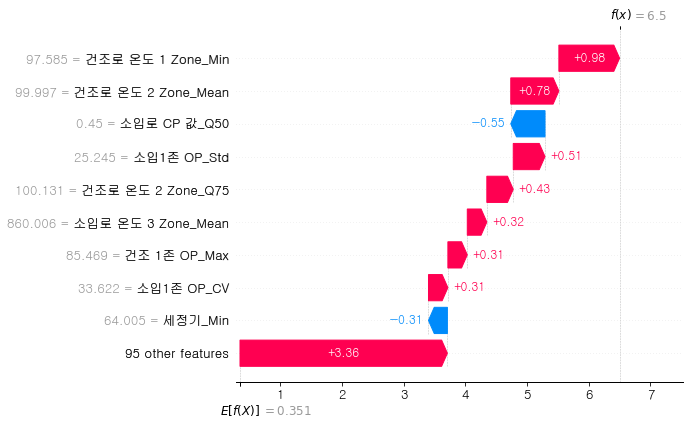

In [ ]:
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.plots.force(shap_values[0])

In [ ]:
shap.plots.waterfall(shap_values[1])

In [ ]:
shap.plots.force(shap_values[1])

In [ ]:
shap.plots.force(shap_values)

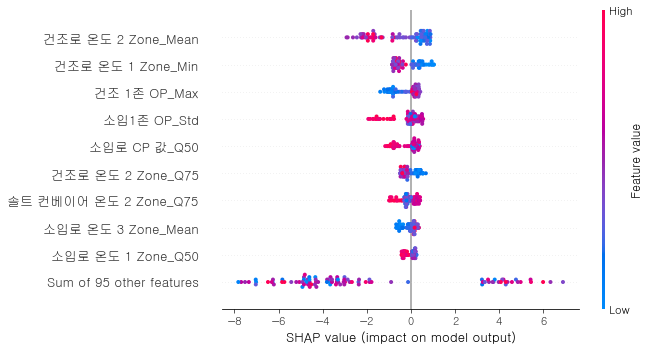

In [ ]:
shap.plots.beeswarm(shap_values)

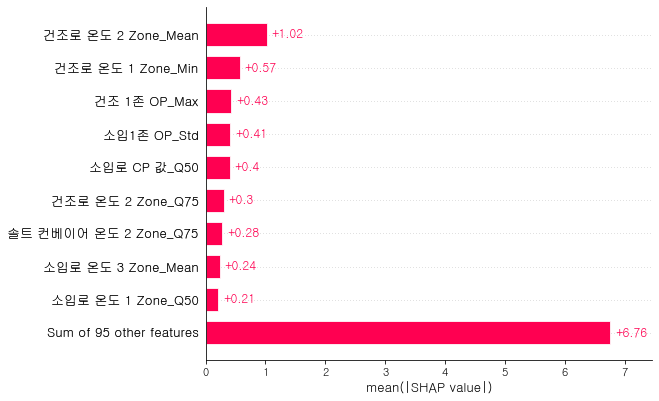

In [ ]:
shap.plots.bar(shap_values)